# Hyperparameter Tuning: GridSearchCV and RandomizedSearchCV

## Overview

**Why Hyperparameter Tuning?**
- Default parameters rarely give best performance
- Finding optimal parameters manually is time-consuming
- Need systematic approach to explore parameter space

## Tuning Strategies

### 1. GridSearchCV
- **Exhaustive search**: Tests all combinations
- ✓ Guaranteed to find best combination in grid
- ✗ Computationally expensive (exponential with parameters)
- **Use when**: Small parameter space, computational resources available

### 2. RandomizedSearchCV
- **Random sampling**: Tests random combinations
- ✓ Much faster than grid search
- ✓ Can explore wider parameter ranges
- ✗ May miss optimal combination
- **Use when**: Large parameter space, limited time/resources

### 3. Nested Cross-Validation
- **Unbiased evaluation**: Separates tuning from evaluation
- ✓ Prevents overfitting to validation set
- ✓ More reliable performance estimates
- ✗ Computationally expensive
- **Use when**: Need unbiased final model assessment

## Setup and Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.datasets import load_breast_cancer, load_digits, load_wine
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    KFold,
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, make_scorer
from scipy.stats import randint, uniform

np.random.seed(42)
print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. GridSearchCV - Exhaustive Search

### 1.1 Basic GridSearchCV

In [2]:
# Load dataset
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

print("Breast Cancer Dataset:")
print(f"Samples: {len(X)}, Features: {X.shape[1]}")
print(f"Classes: {cancer.target_names}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

print(f"\nParameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal combinations: {total_combinations}")
print(f"With 5-fold CV: {total_combinations * 5} model fits")

Breast Cancer Dataset:
Samples: 569, Features: 30
Classes: ['malignant' 'benign']

Parameter Grid:
  C: [0.1, 1, 10, 100]
  gamma: ['scale', 'auto', 0.001, 0.01, 0.1]
  kernel: ['rbf', 'linear']

Total combinations: 40
With 5-fold CV: 200 model fits


In [3]:
# Create GridSearchCV
grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,         # Use all CPU cores
    verbose=2,         # Show progress
    return_train_score=True
)

# Fit (this searches through all combinations)
print("\nStarting Grid Search...")
start_time = time()
grid_search.fit(X_train, y_train)
elapsed_time = time() - start_time

print(f"\n✓ Grid Search completed in {elapsed_time:.2f} seconds")


Starting Grid Search...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

✓ Grid Search completed in 27.57 seconds


In [4]:
# Best parameters and score
print("\n" + "="*70)
print("GRID SEARCH RESULTS")
print("="*70)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Best Estimator: {grid_search.best_estimator_}")

# Evaluate on test set
y_pred = grid_search.predict(X_test)
test_score = accuracy_score(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {test_score:.4f}")

# Compare with default parameters
default_model = SVC(random_state=42)
default_model.fit(X_train, y_train)
default_score = default_model.score(X_test, y_test)

print(f"\nDefault Parameters:")
print(f"  Accuracy: {default_score:.4f}")
print(f"\nImprovement: {(test_score - default_score):.4f} ({(test_score/default_score - 1)*100:.1f}%)")


GRID SEARCH RESULTS

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV Score: 0.9560
Best Estimator: SVC(C=1, kernel='linear', random_state=42)

Test Set Performance:
  Accuracy: 0.9561

Default Parameters:
  Accuracy: 0.9298

Improvement: 0.0263 (2.8%)


### 1.2 Analyzing Grid Search Results

In [5]:
# Get detailed results
results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 configurations
print("\nTop 10 Parameter Combinations:")
print("="*70)
top_results = results_df[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
].sort_values('rank_test_score').head(10)

for idx, row in top_results.iterrows():
    print(f"\nRank {row['rank_test_score']}: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"  Params: {row['params']}")


Top 10 Parameter Combinations:

Rank 1: 0.9560 (±0.0155)
  Params: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}

Rank 1: 0.9560 (±0.0197)
  Params: {'C': 100, 'gamma': 0.01, 'kernel': 'linear'}

Rank 1: 0.9560 (±0.0197)
  Params: {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}

Rank 1: 0.9560 (±0.0197)
  Params: {'C': 100, 'gamma': 'auto', 'kernel': 'linear'}

Rank 1: 0.9560 (±0.0197)
  Params: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}

Rank 1: 0.9560 (±0.0155)
  Params: {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}

Rank 1: 0.9560 (±0.0155)
  Params: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

Rank 1: 0.9560 (±0.0155)
  Params: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}

Rank 1: 0.9560 (±0.0155)
  Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Rank 1: 0.9560 (±0.0197)
  Params: {'C': 100, 'gamma': 0.1, 'kernel': 'linear'}


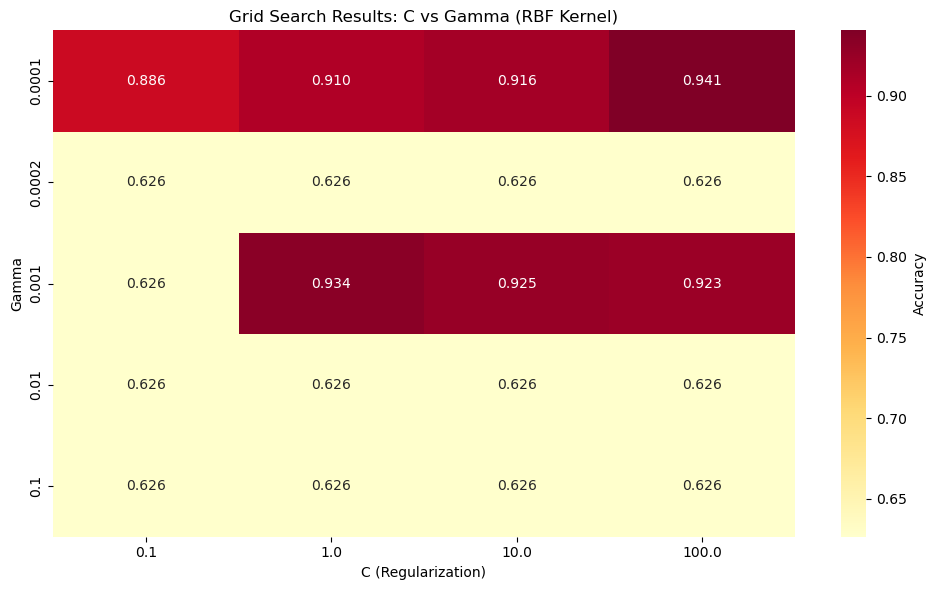

In [6]:
# Visualize parameter effects (for numeric parameters)
# Extract C and gamma values for rbf kernel
rbf_results = results_df[results_df['param_kernel'] == 'rbf'].copy()

# Create pivot table for heatmap
if len(rbf_results) > 0:
    # Convert to numeric
    rbf_results['C_val'] = rbf_results['param_C']
    rbf_results['gamma_val'] = rbf_results['param_gamma'].apply(
        lambda x: 0.0001 if x == 'scale' else (0.0002 if x == 'auto' else x)
    )
    
    pivot = rbf_results.pivot_table(
        values='mean_test_score',
        index='gamma_val',
        columns='C_val'
    )
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Accuracy'})
    plt.title('Grid Search Results: C vs Gamma (RBF Kernel)')
    plt.xlabel('C (Regularization)')
    plt.ylabel('Gamma')
    plt.tight_layout()
    plt.show()

## 2. RandomizedSearchCV - Faster Alternative

### 2.1 Basic RandomizedSearchCV

In [ ]:
# Define parameter distributions
param_distributions = {
    'C': uniform(0.1, 100),              # Continuous uniform distribution
    'gamma': uniform(0.0001, 0.1),       # Continuous uniform distribution
    'kernel': ['rbf', 'linear', 'poly']  # Discrete choices
}

print("Parameter Distributions:")
print("  C: uniform(0.1, 100) - continuous")
print("  gamma: uniform(0.0001, 0.1) - continuous")
print("  kernel: ['rbf', 'linear', 'poly'] - discrete")

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    SVC(random_state=42),
    param_distributions,
    n_iter=50,         # Number of random combinations to try
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

print(f"\nTotal evaluations: {50} random combinations × 5 folds = {50*5} fits")
print("(Much less than GridSearch's {})\n".format(total_combinations * 5))

# Fit
print("Starting Randomized Search...")
start_time = time()
random_search.fit(X_train, y_train)
elapsed_time = time() - start_time

print(f"\n✓ Randomized Search completed in {elapsed_time:.2f} seconds")

Parameter Distributions:
  C: uniform(0.1, 100) - continuous
  gamma: uniform(0.0001, 0.1) - continuous
  kernel: ['rbf', 'linear', 'poly'] - discrete

Total evaluations: 50 random combinations × 5 folds = 250 fits
(Much less than GridSearch's 200)

Starting Randomized Search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
# Results
print("\n" + "="*70)
print("RANDOMIZED SEARCH RESULTS")
print("="*70)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best CV Score: {random_search.best_score_:.4f}")

# Test set performance
y_pred_random = random_search.predict(X_test)
test_score_random = accuracy_score(y_test, y_pred_random)
print(f"\nTest Set Accuracy: {test_score_random:.4f}")

# Compare with GridSearch
print(f"\n" + "="*70)
print("COMPARISON: GridSearch vs RandomizedSearch")
print("="*70)
print(f"\nGridSearch:")
print(f"  Best CV Score: {grid_search.best_score_:.4f}")
print(f"  Test Accuracy: {test_score:.4f}")
print(f"\nRandomizedSearch:")
print(f"  Best CV Score: {random_search.best_score_:.4f}")
print(f"  Test Accuracy: {test_score_random:.4f}")
print(f"\n💡 RandomizedSearch achieved similar performance with fewer evaluations!")

### 2.2 RandomizedSearch for Random Forest

In [ ]:
# Load larger dataset
digits = load_digits()
X_digits, y_digits = digits.data, digits.target

print(f"Digits Dataset: {X_digits.shape[0]} samples, {X_digits.shape[1]} features, {len(np.unique(y_digits))} classes")

# Split
X_tr_dig, X_te_dig, y_tr_dig, y_te_dig = train_test_split(
    X_digits, y_digits, test_size=0.2, random_state=42, stratify=y_digits
)

# Define extensive parameter space for Random Forest
rf_param_dist = {
    'n_estimators': randint(50, 500),           # Discrete uniform
    'max_depth': randint(5, 50),                # Discrete uniform
    'min_samples_split': randint(2, 20),       # Discrete uniform
    'min_samples_leaf': randint(1, 10),        # Discrete uniform
    'max_features': ['sqrt', 'log2', None],    # Discrete choices
    'bootstrap': [True, False]                  # Boolean
}

print("\nRandom Forest Parameter Space:")
for param, dist in rf_param_dist.items():
    print(f"  {param}: {dist}")

# Randomized search
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_dist,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("\nSearching for best parameters...")
rf_random.fit(X_tr_dig, y_tr_dig)

print(f"\nBest Parameters:")
for param, value in rf_random.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Accuracy: {rf_random.best_score_:.4f}")
print(f"Test Accuracy: {rf_random.score(X_te_dig, y_te_dig):.4f}")

## 3. Tuning Pipelines

### 3.1 GridSearch with Pipeline

In [ ]:
# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42))
])

# Parameter grid for pipeline (note the naming: step__parameter)
pipeline_params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [0.001, 0.01, 0.1],
    'classifier__kernel': ['rbf', 'linear']
}

print("Pipeline:")
print(pipeline)
print("\nParameter Grid (pipeline syntax):")
for param, values in pipeline_params.items():
    print(f"  {param}: {values}")

# Grid search on pipeline
pipeline_grid = GridSearchCV(
    pipeline,
    pipeline_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

pipeline_grid.fit(X_train, y_train)

print(f"\nBest Pipeline Parameters: {pipeline_grid.best_params_}")
print(f"Best CV Score: {pipeline_grid.best_score_:.4f}")
print(f"Test Accuracy: {pipeline_grid.score(X_test, y_test):.4f}")

### 3.2 Comparing Multiple Models

In [ ]:
# Define models and their parameter spaces
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': [0.001, 0.01, 0.1],
            'kernel': ['rbf']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    }
}

print("Comparing Multiple Models with Hyperparameter Tuning")
print("="*70)

results = []
for name, config in models.items():
    print(f"\nTuning {name}...")
    
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    results.append({
        'Model': name,
        'Best CV Score': grid.best_score_,
        'Test Score': grid.score(X_test, y_test),
        'Best Params': grid.best_params_
    })
    
    print(f"  Best CV Score: {grid.best_score_:.4f}")
    print(f"  Test Score: {grid.score(X_test, y_test):.4f}")

# Summary
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(results_df[['Model', 'Best CV Score', 'Test Score']].to_string(index=False))

best_model = results_df.loc[results_df['Test Score'].idxmax()]
print(f"\n🏆 Best Model: {best_model['Model']} (Test Score: {best_model['Test Score']:.4f})")

## 4. Nested Cross-Validation

**Why Nested CV?**
- Regular GridSearchCV uses same data for tuning and evaluation
- This can lead to overfitting to validation set
- Nested CV provides unbiased performance estimate

**Structure:**
```
Outer Loop (evaluation): K folds
  Inner Loop (tuning): M folds
    - Find best parameters on training folds
  - Evaluate with best parameters on test fold
Final Score = Average of outer loop scores
```

In [ ]:
# Load wine dataset for nested CV example
wine = load_wine()
X_wine, y_wine = wine.data, wine.target

print("Wine Dataset:")
print(f"Samples: {len(X_wine)}, Features: {X_wine.shape[1]}, Classes: {len(np.unique(y_wine))}")

# Define parameter grid
param_grid_nested = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

# Nested cross-validation
print("\nPerforming Nested Cross-Validation...")
print("  Outer CV: 5 folds (for evaluation)")
print("  Inner CV: 3 folds (for hyperparameter tuning)")

# Outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Inner CV
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

nested_scores = []
best_params_list = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_wine, y_wine), 1):
    print(f"\nOuter Fold {fold}/5:")
    
    X_train_outer, X_test_outer = X_wine[train_idx], X_wine[test_idx]
    y_train_outer, y_test_outer = y_wine[train_idx], y_wine[test_idx]
    
    # Inner grid search
    inner_grid = GridSearchCV(
        SVC(random_state=42),
        param_grid_nested,
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )
    
    inner_grid.fit(X_train_outer, y_train_outer)
    
    # Evaluate on outer test fold
    score = inner_grid.score(X_test_outer, y_test_outer)
    nested_scores.append(score)
    best_params_list.append(inner_grid.best_params_)
    
    print(f"  Best params: {inner_grid.best_params_}")
    print(f"  Inner CV score: {inner_grid.best_score_:.4f}")
    print(f"  Outer test score: {score:.4f}")

# Final results
print("\n" + "="*70)
print("NESTED CROSS-VALIDATION RESULTS")
print("="*70)
print(f"\nOuter fold scores: {[f'{s:.4f}' for s in nested_scores]}")
print(f"\nMean Score: {np.mean(nested_scores):.4f}")
print(f"Std Score: {np.std(nested_scores):.4f}")
print(f"\n✓ This is an unbiased estimate of model performance!")

In [ ]:
# Compare with regular GridSearchCV
print("\nComparison: Nested CV vs Regular GridSearchCV")
print("="*70)

# Regular GridSearchCV (potentially biased)
regular_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid_nested,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Get CV score (this is what grid search reports)
regular_grid.fit(X_wine, y_wine)
regular_cv_score = regular_grid.best_score_

print(f"\nRegular GridSearchCV:")
print(f"  Best CV Score: {regular_cv_score:.4f}")
print(f"  (May be optimistically biased)")

print(f"\nNested CV:")
print(f"  Mean Score: {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")
print(f"  (Unbiased estimate)")

print(f"\nDifference: {regular_cv_score - np.mean(nested_scores):.4f}")
print("\n💡 Nested CV usually gives lower (more realistic) scores")

## 5. Best Practices and Tips

In [ ]:
print("Hyperparameter Tuning Best Practices")
print("="*70)

practices = [
    ("1. Start with coarse grid, refine iteratively",
     "Grid: [0.1, 1, 10, 100] → Refine: [8, 9, 10, 11, 12]"),
    
    ("2. Use RandomizedSearch for initial exploration",
     "Then GridSearch around best region"),
    
    ("3. Use log scale for large ranges",
     "C: [0.001, 0.01, 0.1, 1, 10, 100] instead of linear"),
    
    ("4. Set n_jobs=-1 for parallel processing",
     "Speeds up search significantly"),
    
    ("5. Always use stratified splits for classification",
     "cv=StratifiedKFold() instead of int"),
    
    ("6. Include preprocessing in pipeline",
     "Prevents data leakage"),
    
    ("7. Use nested CV for unbiased evaluation",
     "When reporting final model performance"),
    
    ("8. Consider computational cost",
     "Large grid × deep trees × big data = very slow"),
    
    ("9. Save cv_results_ for analysis",
     "grid.cv_results_ contains detailed information"),
    
    ("10. Set random_state for reproducibility",
     "In both model and search object")
]

for practice, explanation in practices:
    print(f"\n{practice}")
    print(f"  → {explanation}")

## 6. Decision Guide

In [ ]:
# Create decision guide
guide = pd.DataFrame({
    'Scenario': [
        'Small parameter space (<100 combinations)',
        'Large parameter space (>1000 combinations)',
        'Continuous parameters',
        'Limited computational resources',
        'Need best possible model',
        'Initial exploration',
        'Final model evaluation',
        'Model comparison',
        'Very small dataset',
        'Production deployment'
    ],
    'Recommended Method': [
        'GridSearchCV',
        'RandomizedSearchCV',
        'RandomizedSearchCV',
        'RandomizedSearchCV with fewer iterations',
        'GridSearchCV (after RandomizedSearch)',
        'RandomizedSearchCV',
        'Nested CV',
        'GridSearchCV on each model',
        'Nested CV with fewer folds',
        'Retrain with best params on all data'
    ],
    'CV Folds': [
        '5',
        '3-5',
        '5',
        '3',
        '5-10',
        '3',
        '5 outer, 3 inner',
        '5',
        '3',
        'All data'
    ]
})

print("\nDecision Guide: When to Use Which Method")
print("="*90)
print(guide.to_string(index=False))

## Summary

### Quick Reference

```python
# GridSearchCV - Exhaustive search
param_grid = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# RandomizedSearchCV - Random sampling
param_dist = {'C': uniform(0.1, 100), 'gamma': uniform(0.001, 0.1)}
random = RandomizedSearchCV(model, param_dist, n_iter=50, cv=5, n_jobs=-1)
random.fit(X_train, y_train)

# Pipeline tuning
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', SVC())])
params = {'clf__C': [0.1, 1, 10], 'clf__gamma': [0.001, 0.01]}
grid = GridSearchCV(pipeline, params, cv=5)

# Nested CV - Unbiased evaluation
outer_cv = KFold(n_splits=5)
for train, test in outer_cv.split(X):
    inner_grid = GridSearchCV(model, params, cv=3)
    inner_grid.fit(X[train], y[train])
    score = inner_grid.score(X[test], y[test])
```

### Key Takeaways

1. **GridSearch**: Guaranteed to find best in grid, but expensive
2. **RandomizedSearch**: Much faster, often finds near-optimal solutions
3. **Start random, refine with grid**: Best strategy for large spaces
4. **Nested CV**: Use for unbiased final performance estimate
5. **Pipeline tuning**: Prevents data leakage, cleaner code
6. **Use parallel processing**: Set n_jobs=-1
7. **Stratified CV**: Essential for classification
8. **Compare multiple models**: Tune each, then compare on test set

### Common Pitfalls

- ❌ Testing on same data used for tuning
- ❌ Not scaling before tuning distance-based models
- ❌ Using too many folds with small datasets
- ❌ Forgetting to set random_state
- ❌ Tuning on test set (never do this!)
- ❌ Grid search with very large parameter spaces